**Step 1: Import Libraries**

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

**Step 2: Load dataset**

In [38]:
df = pd.read_csv("/kaggle/input/students-performance-in-exams/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [39]:
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.head()

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


**Checking Missing Values**

In [40]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

**Step 3: Exploratory Data Analysis (EDA)**

**Distribution of scores**

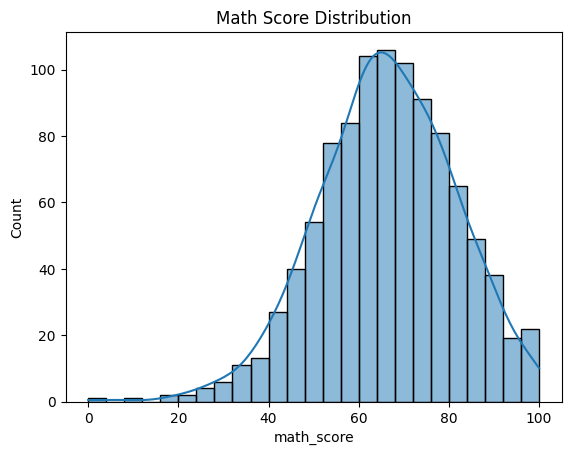

In [41]:
sns.histplot(df["math_score"], kde=True)
plt.title("Math Score Distribution")
plt.show()

**Pairplot**

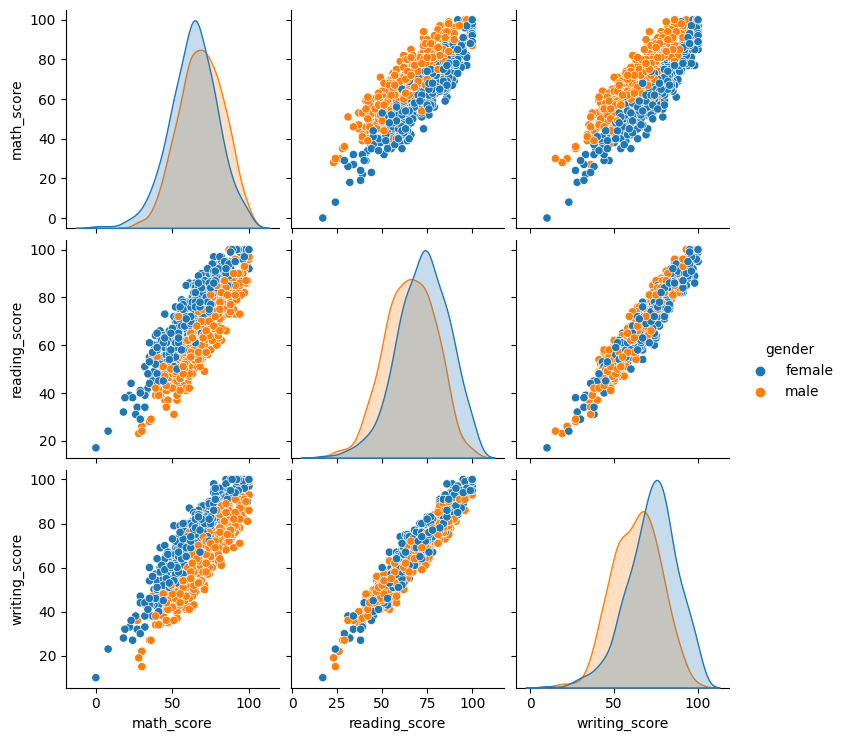

In [42]:
sns.pairplot(df, vars=["math_score", "reading_score", "writing_score"], hue="gender")
plt.show()

**Boxplot for test preparation course**

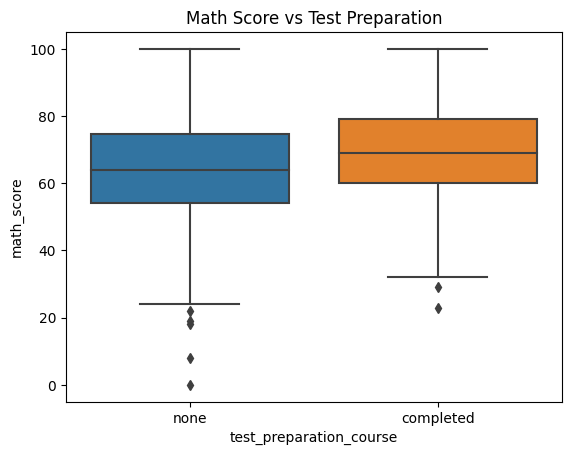

In [43]:
sns.boxplot(x="test_preparation_course", y="math_score", data=df)
plt.title("Math Score vs Test Preparation")
plt.show()

**IQR-based Outlier Removal on target (math_score)**

In [44]:
Q1 = df['math_score'].quantile(0.25)
Q3 = df['math_score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['math_score'] >= lower_bound) & (df['math_score'] <= upper_bound)]

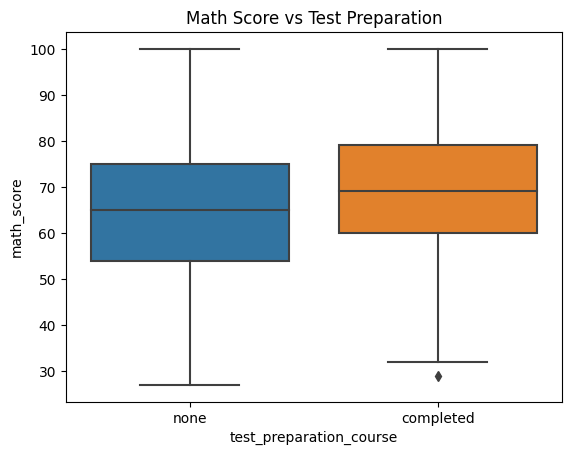

In [45]:
sns.boxplot(x="test_preparation_course", y="math_score", data=df)
plt.title("Math Score vs Test Preparation")
plt.show()

**Step 4: Prepare Features & Target**

In [46]:
X = df.drop("math_score", axis=1)
y = df["math_score"]

categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

**Step 5: Preprocessing Pipeline**

In [47]:
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_cols),
    ("num", StandardScaler(), numerical_cols)
])

**Step 6: Train-Test Split**

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Step 7: Models define for Without Tuning**

In [49]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

**Train and Evaluate**

In [50]:
results_no_tuning = []
preds_no_tuning = {}

for name, model in models.items():
    pipe = Pipeline([("pre", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    preds_no_tuning[name] = preds
    results_no_tuning.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    })

df_no_tuning = pd.DataFrame(results_no_tuning).sort_values(by="R2", ascending=False)

print("Evaluation WITHOUT Tuning")
print(df_no_tuning)

Evaluation WITHOUT Tuning
              Model       MAE      RMSE        R2
0  LinearRegression  4.085098  5.087236  0.886912
1             Ridge  4.095243  5.092712  0.886668
4  GradientBoosting  4.372397  5.457630  0.869845
3      RandomForest  4.505586  5.567553  0.864549
2             Lasso  4.986176  6.335080  0.824629
5               SVR  5.414422  7.125983  0.778107


**Step 8: Models define for With Tuning**

In [51]:
tuned_models = {
    "Ridge": {
        "model": Ridge(),
        "params": {"model__alpha": [0.1, 1.0, 10.0]}
    },
    "Lasso": {
        "model": Lasso(),
        "params": {"model__alpha": [0.001, 0.01, 0.1, 1.0]}
    },
    "SVR": {
        "model": SVR(),
        "params": {"model__C": [0.1, 1, 10], "model__gamma": ["scale", "auto"]}
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {"model__n_estimators": [100, 200], "model__max_depth": [None, 10, 20]}
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {"model__n_estimators": [100, 200], "model__learning_rate": [0.05, 0.1], "model__max_depth": [3, 5]}
    }
}


In [52]:
results_tuned = []
best_estimators = {}

for name, mp in tuned_models.items():
    pipe = Pipeline([("pre", preprocessor), ("model", mp["model"])])
    grid = GridSearchCV(pipe, mp["params"], cv=5, scoring="r2", n_jobs=-1)
    grid.fit(X_train, y_train)
    preds = grid.predict(X_test)
    best_estimators[name] = grid.best_estimator_
    results_tuned.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds),
        "Best Params": grid.best_params_
    })

df_tuned = pd.DataFrame(results_tuned).sort_values(by="R2", ascending=False)

print("\nEvaluation WITH Tuning")
print(df_tuned)


Evaluation WITH Tuning
              Model       MAE      RMSE        R2  \
0             Ridge  4.095243  5.092712  0.886668   
1             Lasso  4.097331  5.094180  0.886603   
2               SVR  4.368283  5.385760  0.873250   
4  GradientBoosting  4.372397  5.457630  0.869845   
3      RandomForest  4.496842  5.547891  0.865504   

                                         Best Params  
0                              {'model__alpha': 1.0}  
1                             {'model__alpha': 0.01}  
2           {'model__C': 10, 'model__gamma': 'auto'}  
4  {'model__learning_rate': 0.1, 'model__max_dept...  
3  {'model__max_depth': 10, 'model__n_estimators'...  


**Step 9: Comparison of All Models**

In [53]:
comparison_df = pd.merge(
    df_no_tuning,
    df_tuned.drop(columns=["Best Params"]),  
    on="Model",
    suffixes=("_NoTuning", "_Tuned")
)

comparison_df = comparison_df.sort_values(by="R2_Tuned", ascending=False)

print("Comparison of Models: No Tuning vs With Tuning\n")
print(comparison_df)


Comparison of Models: No Tuning vs With Tuning

              Model  MAE_NoTuning  RMSE_NoTuning  R2_NoTuning  MAE_Tuned  \
0             Ridge      4.095243       5.092712     0.886668   4.095243   
3             Lasso      4.986176       6.335080     0.824629   4.097331   
4               SVR      5.414422       7.125983     0.778107   4.368283   
1  GradientBoosting      4.372397       5.457630     0.869845   4.372397   
2      RandomForest      4.505586       5.567553     0.864549   4.496842   

   RMSE_Tuned  R2_Tuned  
0    5.092712  0.886668  
3    5.094180  0.886603  
4    5.385760  0.873250  
1    5.457630  0.869845  
2    5.547891  0.865504  


**Step 10: Prediction with Best Model**

In [54]:
best_model_no_tuning_name = df_no_tuning.iloc[0]["Model"]
best_model_tuned_name = df_tuned.iloc[0]["Model"]

best_model_no_tuning = Pipeline([("pre", preprocessor), ("model", models[best_model_no_tuning_name])])
best_model_no_tuning.fit(X_train, y_train)

best_model_tuned = best_estimators[best_model_tuned_name]

preds_no = best_model_no_tuning.predict(X_test)
preds_tuned = best_model_tuned.predict(X_test)

compare_preds = pd.DataFrame({
    "Actual": y_test.values,
    f"Predicted_{best_model_no_tuning_name}_NoTuning": preds_no.round(2),
    f"Predicted_{best_model_tuned_name}_Tuned": preds_tuned.round(2)
})
print("FOR MATH SCORE...")
print(compare_preds.head(15))

FOR MATH SCORE...
    Actual  Predicted_LinearRegression_NoTuning  Predicted_Ridge_Tuned
0       83                                77.90                  77.87
1       83                                85.84                  85.80
2       68                                73.27                  73.30
3       67                                67.98                  67.93
4       65                                65.79                  65.80
5       75                                71.07                  71.04
6       70                                64.19                  64.27
7       70                                63.90                  63.80
8       39                                39.62                  39.71
9       64                                52.25                  52.36
10      27                                24.43                  24.54
11      81                                78.72                  78.62
12      41                                39.21            

**This is only for math score...**